# Course 1 - 神经网络和深度学习 - 第三周作业 - 带有一个隐藏层的平面数据分类

# 开始之前
   在开始之前，我们简单说一下我们要做什么。我们要建立一个神经网络，它有一个隐藏层。你会发现这个模型和上一个逻辑回归实现的模型有很大的区别。你可以跟随我的步骤在Jupyter Notebook中一步步地把代码填进去。在这篇文章中，我们会讲到以下的知识：

构建具有单隐藏层的2类分类神经网络。
使用具有非线性激活功能激活函数，例如tanh。
计算交叉熵损失（损失函数）。
实现向前和向后传播。
# 1、准备软件包
我们需要准备一些软件包：

numpy：是用Python进行科学计算的基本软件包。
sklearn：为数据挖掘和数据分析提供的简单高效的工具。
matplotlib ：是一个用于在Python中绘制图表的库。
testCases：提供了一些测试示例来评估函数的正确性，参见下载的资料或者在底部查看它的代码。
planar_utils ：提供了在这个任务中使用的各种有用的功能，参见下载的资料或者在底部查看它的代码。

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

#%matplotlib inline #如果你使用用的是Jupyter Notebook的话请取消注释。

np.random.seed(1) #设置一个固定的随机种子，以保证接下来的步骤中我们的结果是一致的。

# 2、加载和查看数据集
首先，我们来看看我们将要使用的数据集， 下面的代码会将一个花的图案的2类数据集加载到变量X和Y中。

In [5]:
X, Y = load_planar_dataset()

把数据集加载完成了，然后使用matplotlib可视化数据集，代码如下：

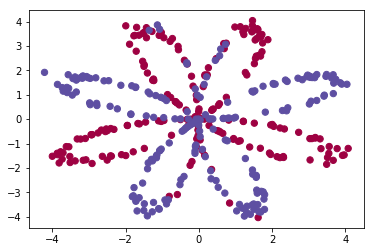

In [7]:
# plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral) #绘制散点图

# 上一语句如出现问题，请使用下面的语句：
plt.scatter(X[0, :], X[1, :], c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral) #绘制散点图

 数据看起来像一朵红色（y = 0）和一些蓝色（y = 1）的数据点的花朵的图案。 我们的目标是建立一个模型来适应这些数据。现在，我们已经有了以下的东西：

X：一个numpy的矩阵，包含了这些数据点的数值;
Y：一个numpy的向量，对应着的是X的标签【0 | 1】（红色:0 ， 蓝色 :1）
我们继续来仔细地看数据：

In [10]:
shape_X = X.shape
shape_Y = Y.shape
m = Y.shape[1]  # 训练集里面的数量

print ("X的维度为: " + str(shape_X))
print ("Y的维度为: " + str(shape_Y))
print ("数据集里面的数据有：" + str(m) + " 个")

X的维度为: (2, 400)
Y的维度为: (1, 400)
数据集里面的数据有：400 个


# 3、简单的Logistic回归
  在构建完整的神经网络之前，先让我们看看逻辑回归在这个问题上的表现如何，我们可以使用sklearn的内置函数来做到这一点， 运行下面的代码来训练数据集上的逻辑回归分类器。

In [11]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T,np.squeeY.T)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

我们可以把逻辑回归分类器的分类绘制出来：

逻辑回归的准确性： 47 % (正确标记的数据点所占的百分比)


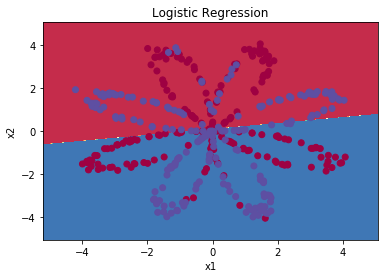

In [14]:
plot_decision_boundary(lambda x: clf.predict(x), X, np.squeeze(Y)) #绘制决策边界
plt.title("Logistic Regression") #图标题
LR_predictions  = clf.predict(X.T) #预测结果
print ("逻辑回归的准确性： %d " % float((np.dot(Y, LR_predictions) + 
        np.dot(1 - Y,1 - LR_predictions)) / float(Y.size) * 100) +
       "% " + "(正确标记的数据点所占的百分比)")

准确性只有47%的原因是数据集不是线性可分的，所以逻辑回归表现不佳，现在我们正式开始构建神经网络。

# 4、搭建神经网络
**我们要搭建的神经网络模型如下图：**
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**当然还有我们的理论基础（不懂可以去仔细看看视频）：**

对于一个样本 $x^{(i)}$有:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

给出所有示例的预测结果，可以按如下方式计算成本函数$J$ : 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**构建神经网络的一般方法是：** 
1. 定义神经网络结构（输入单元的数量，隐藏单元的数量等）。 
2. 初始化模型的参数 
3. 循环：



- n实施前向传播
- 计算损失
- 实现向后传播
- 更新参数（梯度下降）
           
我们要它们合并到一个nn_model() 函数中，当我们构建好了nn_model（）并学习了正确的参数，我们就可以预测新的数据。

##  4.1定义神经网络结构
在构建之前，我们要先把神经网络的结构给定义好：

n_x: 输入层的数量

n_h: 隐藏层的数量（这里设置为4）

n_y: 输出层的数量

In [18]:
def layer_sizes(X , Y):
    """
    参数：
     X - 输入数据集,维度为（输入的数量，训练/测试的数量）
     Y - 标签，维度为（输出的数量，训练/测试数量）

    返回：
     n_x - 输入层的数量
     n_h - 隐藏层的数量
     n_y - 输出层的数量
    """
    n_x = X.shape[0] #输入层
    n_h = 4 #，隐藏层，硬编码为4
    n_y = Y.shape[0] #输出层

    return (n_x,n_h,n_y)

我们来测试一下：

In [19]:
#测试layer_sizes
print("=========================测试layer_sizes=========================")
X_asses , Y_asses = layer_sizes_test_case()
(n_x,n_h,n_y) =  layer_sizes(X_asses,Y_asses)
print("输入层的节点数量为: n_x = " + str(n_x))
print("隐藏层的节点数量为: n_h = " + str(n_h))
print("输出层的节点数量为: n_y = " + str(n_y))

=========================测试layer_sizes=========================
输入层的节点数量为: n_x = 5
隐藏层的节点数量为: n_h = 4
输出层的节点数量为: n_y = 2


## 4.2 初始化模型的参数
在这里，我们要实现函数initialize_parameters()。我们要确保我们的参数大小合适，如果需要的话，请参考上面的神经网络图。 
我们将会用随机值初始化权重矩阵。

- np.random.randn(a，b)* 0.01来随机初始化一个维度为(a，b)的矩阵。
将偏向量初始化为零。 
- np.zeros((a，b))用零初始化矩阵（a，b）

In [20]:
def initialize_parameters( n_x , n_h ,n_y):
    """
    参数：
        n_x - 输入层节点的数量
        n_h - 隐藏层节点的数量
        n_y - 输出层节点的数量

    返回：
        parameters - 包含参数的字典：
            W1 - 权重矩阵,维度为（n_h，n_x）
            b1 - 偏向量，维度为（n_h，1）
            W2 - 权重矩阵，维度为（n_y，n_h）
            b2 - 偏向量，维度为（n_y，1）

    """
    np.random.seed(2) #指定一个随机种子，以便你的输出与我们的一样。
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))

    #使用断言确保我的数据格式是正确的
    assert(W1.shape == ( n_h , n_x ))
    assert(b1.shape == ( n_h , 1 ))
    assert(W2.shape == ( n_y , n_h ))
    assert(b2.shape == ( n_y , 1 ))

    parameters = {"W1" : W1,
                  "b1" : b1,
                  "W2" : W2,
                  "b2" : b2 }

    return parameters

测试一下我们的代码：

In [21]:
#测试initialize_parameters
print("=========================测试initialize_parameters=========================")    
n_x , n_h , n_y = initialize_parameters_test_case()
parameters = initialize_parameters(n_x , n_h , n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

=========================测试initialize_parameters=========================
W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


## 4.3 循环
### 现在要实现前向传播函数forward_propagation()。 
我们可以使用sigmoid()函数，也可以使用np.tanh()函数。 
步骤如下：

- 使用字典类型的parameters（它是initialize_parameters() 的输出）检索每个参数。
- 实现向前传播, 计算Z[1],A[1],Z[2]Z[1],A[1],Z[2] 和 A[2]A[2]（ 训练集里面所有例子的预测向量）。
- 反向传播所需的值存储在“cache”中，cache将作为反向传播函数的输入。

In [22]:
def forward_propagation( X , parameters ):
    """
    参数：
         X - 维度为（n_x，m）的输入数据。
         parameters - 初始化函数（initialize_parameters）的输出

    返回：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型变量
     """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    #前向传播计算A2
    Z1 = np.dot(W1 , X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2 , A1) + b2
    A2 = sigmoid(Z2)
    #使用断言确保我的数据格式是正确的
    assert(A2.shape == (1,X.shape[1]))
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return (A2, cache)

测试一下我的这个功能：

In [23]:
#测试forward_propagation
print("=========================测试forward_propagation=========================") 
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)
print(np.mean(cache["Z1"]), np.mean(cache["A1"]), np.mean(cache["Z2"]), np.mean(cache["A2"]))

=========================测试forward_propagation=========================
-0.0004997557777419902 -0.000496963353231779 0.0004381874509591466 0.500109546852431


现在我们已经计算了$A^{[2]}$ (in the Python variable "`A2`")，$a^{[2](i)}$包含了训练集里每个数值，现在我们就可以构建成本函数了。成本函数为：

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

有很多的方法都可以计算交叉熵损失，比如这个公式：
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$，我们在python中可以这么实现： 
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)                # no need to use a for loop!
```
当然，你也可以使用 `np.multiply()` 然后使用 `np.sum()` 或者直接使用`np.dot()`。 
现在我们正式开始构建计算成本的函数：

In [25]:
def compute_cost(A2,Y,parameters):
    """
    计算方程（6）中给出的交叉熵成本，

    参数：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         Y - "True"标签向量,维度为（1，数量）
         parameters - 一个包含W1，B1，W2和B2的字典类型的变量

    返回：
         成本 - 交叉熵成本给出方程（13）
    """

    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]

    #计算成本
    logprobs = logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    cost = float(np.squeeze(cost))

    assert(isinstance(cost,float))

    return cost

In [26]:
#测试compute_cost
print("=========================测试compute_cost=========================") 
A2 , Y_assess , parameters = compute_cost_test_case()
print("cost = " + str(compute_cost(A2,Y_assess,parameters)))

=========================测试compute_cost=========================
cost = 0.6929198937761266


使用正向传播期间计算的cache，现在可以利用它实现反向传播。

现在我们要开始实现函数backward_propagation（）。

### 向后传播
  说明：反向传播通常是深度学习中最难（数学意义）部分，为了帮助你，这里有反向传播讲座的幻灯片， 由于我们正在构建向量化实现，因此我们将需要使用这下面的六个方程：
<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- 提示:
    - 要计算 dZ1 就需要计算 $g^{[1]'}(Z^{[1]})$。 因为 $g^{[1]}(.)$ 是tanh 激活函数，所以如果 $a = g^{[1]}(z)$ 那么 $g^{[1]'}(z) = 1-a^2$。因此可以用 `(1 - np.power(A1, 2))`计算出$g^{[1]'}(Z^{[1]})$ 。

In [27]:
def backward_propagation(parameters,cache,X,Y):
    """
    使用上述说明搭建反向传播函数。

    参数：
     parameters - 包含我们的参数的一个字典类型的变量。
     cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型的变量。
     X - 输入数据，维度为（2，数量）
     Y - “True”标签，维度为（1，数量）

    返回：
     grads - 包含W和b的导数一个字典类型的变量。
    """
    m = X.shape[1]

    W1 = parameters["W1"]
    W2 = parameters["W2"]

    A1 = cache["A1"]
    A2 = cache["A2"]

    dZ2= A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2 }

    return grads

测试一下反向传播函数：

In [28]:
#测试backward_propagation
print("=========================测试backward_propagation=========================")
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

=========================测试backward_propagation=========================
dW1 = [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1 = [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[0.06589489]]


### 反向传播完成了，我们开始对参数进行更新

更新参数
我们需要使用(dW1, db1, dW2, db2)来更新(W1, b1, W2, b2)。 
更新算法为： 
$ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ ，其中，$\alpha$表示学习速率；$\theta$ 表示参数。

我们需要选择一个良好的学习速率，我们可以看一下下面这两个图(由Adam Harley提供)，下面两个图分别代表了具有良好学习速率（收敛）和不良学习速率（发散）的梯度下降算法。
<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">

In [30]:
def update_parameters(parameters,grads,learning_rate=1.2):
    """
    使用上面给出的梯度下降更新规则更新参数

    参数：
     parameters - 包含参数的字典类型的变量。
     grads - 包含导数值的字典类型的变量。
     learning_rate - 学习速率

    返回：
     parameters - 包含更新参数的字典类型的变量。
    """
    W1,W2 = parameters["W1"],parameters["W2"]
    b1,b2 = parameters["b1"],parameters["b2"]

    dW1,dW2 = grads["dW1"],grads["dW2"]
    db1,db2 = grads["db1"],grads["db2"]

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

测试一下update_parameters():

In [31]:
#测试update_parameters
print("=========================测试update_parameters=========================")
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

=========================测试update_parameters=========================
W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


## 4.4 整合 4.1, 4.2 和4.3部分为 nn_model() 

我们现在把上面的东西整合到nn_model()中，神经网络模型必须以正确的顺序使用先前实现的函数功能。

In [34]:
def nn_model(X,Y,n_h,num_iterations,print_cost=False):
    """
    参数：
        X - 数据集,维度为（2，示例数）
        Y - 标签，维度为（1，示例数）
        n_h - 隐藏层的数量
        num_iterations - 梯度下降循环中的迭代次数
        print_cost - 如果为True，则每1000次迭代打印一次成本数值

    返回：
        parameters - 模型学习的参数，它们可以用来进行预测。
     """

    np.random.seed(3) #指定随机种子
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    parameters = initialize_parameters(n_x,n_h,n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    for i in range(num_iterations):
        A2 , cache = forward_propagation(X,parameters)
        cost = compute_cost(A2,Y,parameters)
        grads = backward_propagation(parameters,cache,X,Y)
        parameters = update_parameters(parameters,grads,learning_rate = 0.5)

        if print_cost and i%1000 == 0:
            print("第 ",i," 次循环，成本为："+str(cost))
    return parameters

测试nn_model()：

In [36]:
#测试nn_model
print("=========================测试nn_model=========================")
X_assess, Y_assess = nn_model_test_case()

parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=False)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

=========================测试nn_model=========================


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


W1 = [[-3.89167767  4.77541602]
 [-6.77960338  1.20272585]
 [-3.88338966  4.78028666]
 [ 6.77958203 -1.20272574]]
b1 = [[ 2.11530892]
 [ 3.41221357]
 [ 2.11585732]
 [-3.41221322]]
W2 = [[-2512.9093032  -2502.70799785 -2512.01655969  2502.65264416]]
b2 = [[-22.29071761]]


参数更新完了我们就可以来进行预测了。

## 4.5 预测
构建predict()来使用模型进行预测， 使用向前传播来预测结果。 

predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  

In [38]:
def predict(parameters,X):
    """
    使用学习的参数，为X中的每个示例预测一个类

    参数：
        parameters - 包含参数的字典类型的变量。
        X - 输入数据（n_x，m）

    返回
        predictions - 我们模型预测的向量（红色：0 /蓝色：1）

     """
    A2 , cache = forward_propagation(X,parameters)
    predictions = np.round(A2) # 对A2内元素进行四舍五入，使其变为只包含0或1元素的矩阵。

    return predictions

测试一下predict

In [39]:
#测试predict
print("=========================测试predict=========================")

parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("预测的平均值 = " + str(np.mean(predictions)))

=========================测试predict=========================
预测的平均值 = 0.6666666666666666


现在我们把所有的东西基本都做完了，我们开始正式运行。

### 正式运行

第  0  次循环，成本为：0.6930480201239823
第  1000  次循环，成本为：0.3098018601352803
第  2000  次循环，成本为：0.2924326333792647
第  3000  次循环，成本为：0.2833492852647412
第  4000  次循环，成本为：0.27678077562979253
第  5000  次循环，成本为：0.26347155088593266
第  6000  次循环，成本为：0.2420441312994077
第  7000  次循环，成本为：0.23552486626608768
第  8000  次循环，成本为：0.23140964509854278
第  9000  次循环，成本为：0.22846408048352365
准确率: 90%


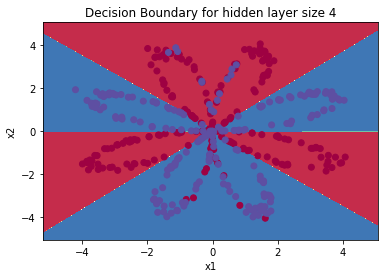

In [42]:
parameters = nn_model(X, Y, n_h = 4, num_iterations=10000, print_cost=True)

#绘制边界
plot_decision_boundary(lambda x: predict(parameters, x.T), X, np.squeeze(Y))
plt.title("Decision Boundary for hidden layer size " + str(4))

predictions = predict(parameters, X)
print ('准确率: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

## 4.6更改隐藏层节点数量
我们上面的实验把隐藏层定为4个节点，现在我们更改隐藏层里面的节点数量，看一看节点数量是否会对结果造成影响。

隐藏层的节点数量： 1  ，准确率: 67.25 %
隐藏层的节点数量： 2  ，准确率: 66.5 %
隐藏层的节点数量： 3  ，准确率: 89.25 %
隐藏层的节点数量： 4  ，准确率: 90.0 %
隐藏层的节点数量： 5  ，准确率: 89.75 %
隐藏层的节点数量： 20  ，准确率: 90.0 %
隐藏层的节点数量： 50  ，准确率: 89.75 %


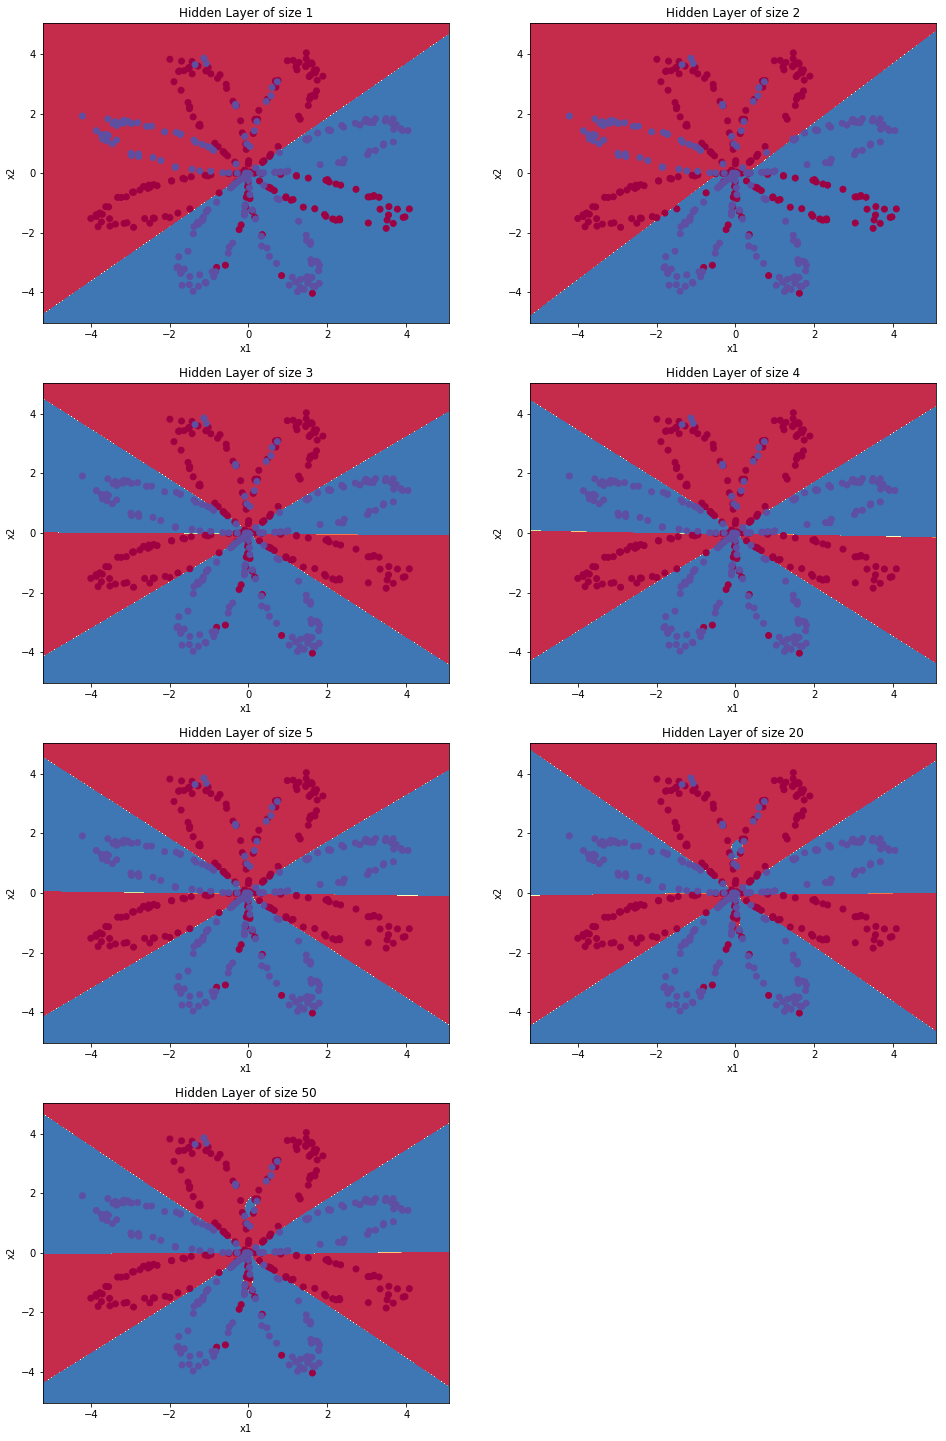

In [44]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50] #隐藏层数量
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations=5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, np.squeeze(Y))
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)
    print ("隐藏层的节点数量： {}  ，准确率: {} %".format(n_h, accuracy))

较大的模型（具有更多隐藏单元）能够更好地适应训练集，直到最终的最大模型过度拟合数据。 
最好的隐藏层大小似乎在n_h = 5附近。实际上，这里的值似乎很适合数据，而且不会引起过度拟合。 
我们还将在后面学习有关正则化的知识，它允许我们使用非常大的模型（如n_h = 50），而不会出现太多过度拟合。

### 【可选】探索
当改变sigmoid激活或ReLU激活的tanh激活时会发生什么？
改变learning_rate的数值会发生什么?
如果我们改变数据集呢？

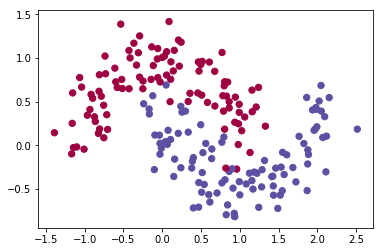

In [47]:
# 数据集
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

dataset = "noisy_moons"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

if dataset == "blobs":
    Y = Y % 2

# plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)

#上一语句如出现问题请使用下面的语句：
plt.scatter(X[0, :], X[1, :], c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral)